# Clean, stitch and analyse red wine data scraped from LCBO and Vivino

This notebook uses data scraped from LCBO and Vivino websites to help a Canadian  decide which red wine offers the most value for a prescribed price point.

The Liquor Control Board of Ontario ("LCBO") is a Crown corporation that retails and distributes alcoholic beverages throughout the Canadian province of Ontario. It regulates the importation and pricing of alcoholic beverages within Ontario.

Vivino is an online wine marketplace and app with a database of over 10 million wines and over 35 million users. It is one of the leading websites for reviews and ratings for wine.

Combining the price information from the LCBO with the rating information would enable an Ontarian red-wine consumer to make choices around their purchases of red wine that offer value. Even if the value is perceived value, it makes a consumer feel better about their purchase. Increased consumer confidence is likely to lead to increased consumption from a general economic standpoint.

## Load required packages and data from scraped .csv files

In [263]:
# Load packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.style.use('ggplot')

In [264]:
# Load interesting package to help with matching of bottle titles from LCBO to Vivino. 
# It uses Levenshtein Distance to calculate differences between sequences used for checking bottle names from 
# lcbo.com vs vivino.com.
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [493]:
# Load .csv files as dataframes

# dataframe dfl for LCBO data
dfl = pd.read_csv('lcbo_redwine.csv')

# datafram dfv for vivno data
dfv = pd.read_csv('vivino_redwine.csv')

In [494]:
# Check the LCBO df
dfl.head()

,name,region,size-mL,container,price,critic,critic_score
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0


In [495]:
# Check the vivino df
dfv.head()

,title,region,country,score,num_reviews
0,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


## Analyse and clean data and stitch Vivino data to LCBO data

### First clean and analyse LCBO data

In [496]:
dfl.dtypes

name             object
region           object
size-mL           int64
container        object
price           float64
critic           object
critic_score    float64
dtype: object

In [497]:
# Summary stats of continuous variables
dfl.describe()

,size-mL,price,critic_score
count,6089.000000,6089.000000,6075.000000
mean,817.182789,109.354533,38.682469
std,404.069473,364.336190,46.024468
min,2.000000,2.350000,0.000000
25%,750.000000,18.950000,0.000000
50%,750.000000,30.750000,0.000000
75%,750.000000,73.000000,93.000000
max,6000.000000,9990.000000,100.000000


In [498]:
# Explore minimum size of 2ml, looks to be incorrect
dfl[dfl['size-mL'] == 2]

,name,region,size-mL,container,price,critic,critic_score
1854,Mazzei Ser Lapo Riserva Chianti Classico 2017,"Tuscany, Italy",2,gift,58.95,JS,95.0



<img src="https://www.lcbo.com/content/dam/lcbo/products/016818.jpg/jcr:content/renditions/cq5dam.web.319.319.jpeg" style="height: 300px;">
*Source: LCBO website*

It turns out that this is actually a giftbox consisting of 2 bottles of 750mL of wine. Hence Replace data point with 1500mL

In [499]:
dfl.loc[dfl['size-mL']==2,'size-mL'] = 1500

In [500]:
dfl.describe()

,size-mL,price,critic_score
count,6089.000000,6089.000000,6075.000000
mean,817.428806,109.354533,38.682469
std,404.029094,364.336190,46.024468
min,6.000000,2.350000,0.000000
25%,750.000000,18.950000,0.000000
50%,750.000000,30.750000,0.000000
75%,750.000000,73.000000,93.000000
max,6000.000000,9990.000000,100.000000


In [501]:
# Looks like there are more issues with size. Explore sizes less than 250ml
dfl[dfl['size-mL'] <250]

,name,region,size-mL,container,price,critic,critic_score
1251,Tedeschi Capitel Monte Olmi Amarone della Valp...,"Veneto, Italy",6,bottle,89.00,none,0.0
1539,Osborne Solaz Tempranillo Cabernet Offer,"Rueda, Spain",6,bottle,72.00,none,0.0
1941,Buscado Vivo o Muerto La Verdad Gualtallary 2016,"Mendoza, Argentina",6,bottle,55.00,TAT,96.0
2644,Bell'Aja Bolgheri 2017,"Tuscany, Italy",6,bottle,37.95,JS,91.0
6080,Copa di Vino Cabernet Sauvignon,"Oregon, USA",200,bottle,4.90,none,0.0
6081,Copa di Vino Merlot,"Oregon, USA",200,bottle,4.90,none,0.0
6086,Peller Family Vineyards Cabernet Merlot,"Ontario, Canada",200,bottle,3.75,none,0.0
6088,Ciao Sangria,"Veneto, Italy",200,can,2.35,none,0.0


Luckily there are only 4 data points to fix (200mL bottles are correct but the 4 with 6 is actually 6 bottles of certain size)

1) Tedeschi is 6 x 125mL
2) Osborne is 6 x 750mL
3) Buscado is 6 x 125mL
4) Bellaja is 6 x 125mL


In [502]:
# Update correct size in mL for gift packs or offers
dfl.loc[1251, 'size-mL'] = 6*125
dfl.loc[1539, 'size-mL'] = 6*750
dfl.loc[1941, 'size-mL'] = 6*125
dfl.loc[2644, 'size-mL'] = 6*125

In [503]:
# Create new variable which normalises price per mL called unit_price
dfl['unit_price'] = dfl['price'] / dfl['size-mL']
dfl.head()

,name,region,size-mL,container,price,critic,critic_score,unit_price
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000


In [504]:
# Everything looks good for continuous variables. When professional critic scores are not available, they have been set to zero
dfl.describe()

,size-mL,price,critic_score,unit_price
count,6089.000000,6089.000000,6075.000000,6089.000000
mean,818.533421,109.354533,38.682469,0.117551
std,406.245591,364.336190,46.024468,0.298816
min,200.000000,2.350000,0.000000,0.007733
25%,750.000000,18.950000,0.000000,0.025267
50%,750.000000,30.750000,0.000000,0.040467
75%,750.000000,73.000000,93.000000,0.096467
max,6000.000000,9990.000000,100.000000,7.960000


In [505]:
# Value count of categorical variables
categorical = ['name', 'region', 'container', 'critic']

for feature in categorical:
    print(dfl[feature].value_counts())
    print('')

Bodacious Smooth Red                                                   4
Château Palmer                                                         4
Peller Family Vineyards Cabernet Merlot                                4
Castelgiocondo Ripe al Convento Riserva Brunello di Montalcino 2013    4
Ornellaia 2017                                                         3
                                                                      ..
Konzelmann Cabernet Sauvignon Reserve VQA                              1
Paddy Borthwick Right Hand Pinot Noir 2016                             1
Comuna Shiraz-Malbec                                                   1
Iliada Cabernet Sauvignon 2017                                         1
Alta Alella GX 2019                                                    1
Name: name, Length: 5890, dtype: int64

California, USA          624
Tuscany, Italy           466
Bordeaux, France         449
Ontario, Canada          333
Burgundy, France         293
            

In [506]:
# Split region into sub-region and country
dfl[['sub_region','country']] = dfl.region.str.split(',',expand=True)
# Drop region since information not needed
dfl.drop('region', axis=1, inplace=True)
# Swap country and region, when no region exists
dfl.loc[dfl['country'].isnull(),['sub_region','country']] = dfl.loc[dfl['country'].isnull(),['country','sub_region']].values

# Extract vintage year from name
vintage = list(map(lambda s: re.findall("\d{4}", s), dfl['name']))
dfl['vintage'] = pd.DataFrame(vintage,columns=['vintage','blank'])['vintage']

#Strip year from name
dfl['name'] = list(map(lambda s: re.findall('\D*', s)[0].strip(), dfl['name']))

In [507]:
# Clean sub_region and country
dfl.loc[dfl['sub_region'].notnull(),['sub_region']] = list(map(lambda s: re.findall('\D*', s)[0].strip(), \
                                                               dfl[dfl['sub_region'].notnull()]['sub_region']))
dfl.loc[dfl['country'].notnull(),['country']] = list(map(lambda s: re.findall('\D*', s)[0].strip(), \
                                                         dfl[dfl['country'].notnull()]['country']))

dfl

,name,size-mL,container,price,critic,critic_score,unit_price,sub_region,country,vintage
0,Château Lafite-Rothschild,1500,bottle,9990.00,RP,98.0,6.660000,Bordeaux,France,1986
1,Masseto,6000,bottle,9950.00,none,0.0,1.658333,Tuscany,Italy,None
2,Château Mouton Rothschild,3000,bottle,6690.00,RP,98.0,2.230000,Bordeaux,France,2005
3,Château Margaux,1500,bottle,6400.00,WS,98.0,4.266667,Bordeaux,France,1983
4,Domaine Leroy Clos de la Roche Grand Cru,750,bottle,5970.00,RP,93.0,7.960000,Burgundy,France,2013
...,...,...,...,...,...,...,...,...,...,...
6084,Bodacious Smooth Red,250,can,3.95,none,0.0,0.015800,Ontario,Canada,None
6085,Stel + Mar Premium Red Wine,250,can,3.90,none,0.0,0.015600,California,USA,None
6086,Peller Family Vineyards Cabernet Merlot,200,bottle,3.75,none,0.0,0.018750,Ontario,Canada,None
6087,Easy Rider Rocket Red can,250,can,3.10,none,0.0,0.012400,Ontario,Canada,None


In [508]:
dfl.dtypes

name             object
size-mL           int64
container        object
price           float64
critic           object
critic_score    float64
unit_price      float64
sub_region       object
country          object
vintage          object
dtype: object

In [509]:
# Value count of categorical variables
categorical = ['sub_region', 'country']

for feature in categorical:
    print(dfl[feature].value_counts())
    print('')

California      624
Tuscany         466
Bordeaux        449
Ontario         333
Burgundy        293
               ... 
Valdepenas        1
Buenos Aires      1
Terra Alta        1
Mallorca          1
Nova Scotia       1
Name: sub_region, Length: 156, dtype: int64

Italy                          1402
France                         1332
USA                             815
Australia                       437
Canada                          412
Spain                           376
Portugal                        315
Chile                           250
Argentina                       217
South Africa                    123
Greece                          103
New Zealand                      97
Israel                           43
Germany                          38
Austria                          29
Georgia                          22
Croatia                          18
Republic of Moldova              14
Ukraine                           7
Armenia                           7
Bulgaria       

In [510]:
# Use Sturgess' rule to suggest optimal number of bins based on sample size
int(1 + 3.322 * np.log(dfl.shape[0]))

29

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016B06F2D910>,
      dtype=object)

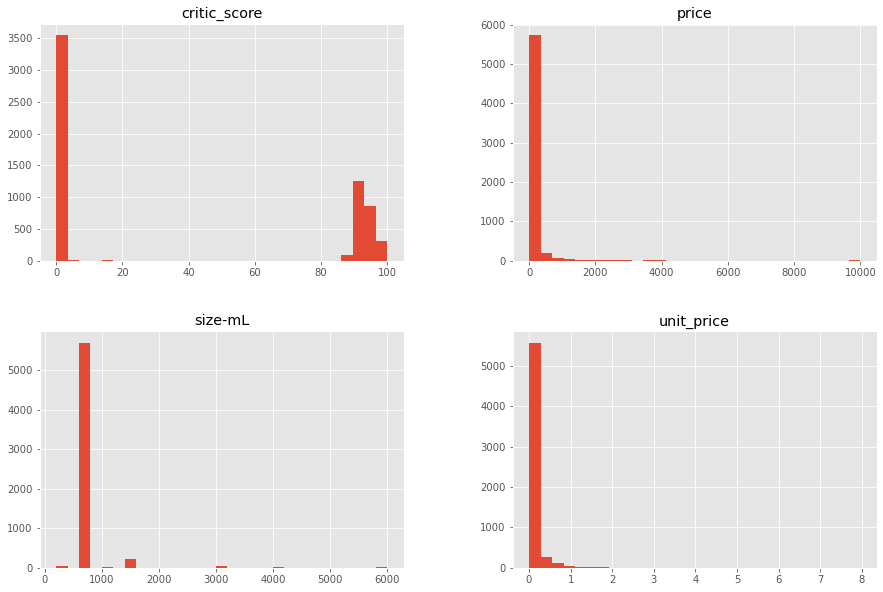

In [512]:
dfl.hist(bins=29, figsize=(15, 10))

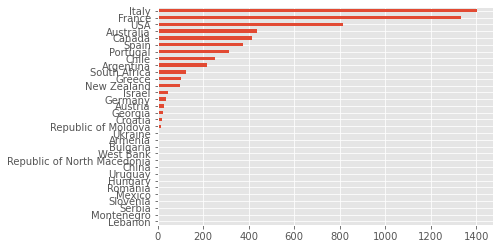

In [513]:
# Chart of item count by country
dfl['country'].value_counts().sort_values(ascending=True).plot(kind='barh')

### Next, clean and analyse Vivino data and stitch with LCBO data

In [514]:
# Summary stats of continuous variables
dfv.describe()

,score,num_reviews
count,6089.000000,6089.000000
mean,3.481228,3585.841846
std,1.169673,9906.982630
min,0.000000,0.000000
25%,3.500000,76.000000
50%,3.800000,467.000000
75%,4.100000,2490.000000
max,4.800000,150466.000000


In [515]:
dfv.head()

,title,region,country,score,num_reviews
0,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


In [516]:
#Clean bottle title, region and country
dfv['title'] = list(map(lambda s: re.findall('\D*', s)[0].strip(), dfv['title']))
dfv['region'] = list(map(lambda s: re.findall('\D*', s)[0].strip(), dfv['region']))
dfv['country'] = list(map(lambda s: re.findall('\D*', s)[0].strip(), dfv['country']))

TypeError: expected string or bytes-like object

In [517]:
# Value count of categorical variables
categorical = ['title', 'region', 'country']

for feature in categorical:
    print(dfv[feature].value_counts())
    print('')

missed                                                 359
Château La France Bordeaux                              35
Antinori Tenuta Tignanello 'Solaia'                     22
Antinori Tenuta Guado al Tasso Matarocchio              21
New Zealand Pinot Noir Marlborough                      19
                                                      ... 
Martin Ray Napa Valley Cabernet Sauvignon                1
Rigoloccio Abundantia Merlot                             1
Jim Simon South Australia Shiraz                         1
Kendall-Jackson Vintner's Reserve Pinot Noir             1
Hex Vom Dasenstein Spätburgunder Feinherb Alte Rebe      1
Name: title, Length: 4773, dtype: int64

missed                        359
Bordeaux                      251
Toscana                       196
California                    184
Napa Valley                   160
                             ... 
Ararat                          1
Kindzmarauli                    1
Colline Lucchesi                1
Lado

### Merge dataframes

The order of names of LCBO webscraped data were used to search for names from the vivino website so simple merge is possible since both dataframes are of the same length.

In [518]:
# Merge dataframes since vivino ratings sourced by LCBO name output
# Create master datafram called df with all the data to be used
df = dfl.merge(dfv, left_index=True, right_index=True)

In [519]:
# Rename columns after merge to distinguish between LCBO and Vivino data
rename_cols = {'name':'lcbo_name', 'sub_region':'lcbo_region',\
               'country_x':'lcbo_country', 'title':'viv_name', 'region':'viv_region',\
               'country_y':'viv_country'}
df = df.rename(columns = rename_cols)

### Use Fuzzy Wuzzy package to calculate match ratios of names from LCBO and Vivino websites

In [520]:
#lcbo_clean_name = list(map(lambda s: re.findall('\D*', s)[0].strip(), df['lcbo_name']))
#viv_clean_name = list(map(lambda s: re.findall('\D*', s)[0].strip(), df['viv_name']))
# Calculate Fuzzy Wuzzy ratios to indicate the strength of name matches
df['fwscore1'] = list(map(lambda s1, s2: fuzz.ratio(s1,s2), df['lcbo_name'], df['viv_name']))
df['fwscore2'] = list(map(lambda s1, s2: fuzz.partial_ratio(s1,s2), df['lcbo_name'], df['viv_name']))
df['fwscore3'] = list(map(lambda s1, s2: fuzz.token_sort_ratio(s1,s2), df['lcbo_name'], df['viv_name']))
df['fwscore4'] = list(map(lambda s1, s2: fuzz.token_set_ratio(s1,s2), df['lcbo_name'], df['viv_name']))

In [521]:
df.head()

,lcbo_name,size-mL,container,price,critic,critic_score,unit_price,lcbo_region,lcbo_country,vintage,viv_name,viv_region,viv_country,score,num_reviews,fwscore1,fwscore2,fwscore3,fwscore4
0,Château Lafite-Rothschild,1500,bottle,9990.0,RP,98.0,6.660000,Bordeaux,France,1986,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14,64,96,66,100
1,Masseto,6000,bottle,9950.0,none,0.0,1.658333,Tuscany,Italy,None,Masseto Toscana,Toscana,Italy,4.7,12022,64,100,64,100
2,Château Mouton Rothschild,3000,bottle,6690.0,RP,98.0,2.230000,Bordeaux,France,2005,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382,63,100,62,100
3,Château Margaux,1500,bottle,6400.0,WS,98.0,4.266667,Bordeaux,France,1983,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0,54,93,56,67
4,Domaine Leroy Clos de la Roche Grand Cru,750,bottle,5970.0,RP,93.0,7.960000,Burgundy,France,2013,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205,89,100,89,100


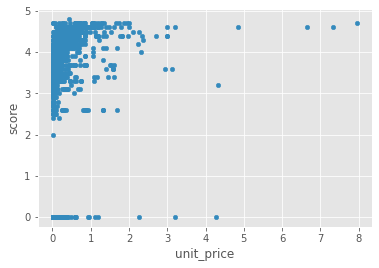

In [522]:
# Chart of item count by country
df.plot(x='unit_price', y='score', kind='scatter')

In [525]:
df[df['score'] >= 4.7].sort_values(by='unit_price')

,lcbo_name,size-mL,container,price,critic,critic_score,unit_price,lcbo_region,lcbo_country,vintage,viv_name,viv_region,viv_country,score,num_reviews,fwscore1,fwscore2,fwscore3,fwscore4
6076,Monte Velho Red,375,bottle,6.95,none,0.0,0.018533,Alentejo,Portugal,2018,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141,56,67,62,75
5533,Monte Velho Red,750,bottle,14.05,none,0.0,0.018733,Alentejo,Portugal,2019,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141,56,67,62,75
1859,Arrepiado Tradicao Red Alentejo,750,bottle,58.40,none,0.0,0.077867,Alentejo,Portugal,2016,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141,55,62,62,70
877,Fiorano Rosso,750,bottle,129.00,RP,91.0,0.172000,Lazio,Italy,2014,Tenuta di Fiorano Alberico Lazio Rosso,Lazio,Italy,4.7,28,51,69,51,100
644,Arrepiado Amma Reserva Red,750,bottle,181.55,none,0.0,0.242067,Alentejo,Portugal,2015,Arrepiado Velho Amma Red,Alentejo,Portugal,4.7,141,72,71,80,86
555,Henschke Cyril Henschke Cabernet Sauvignon/Cab...,750,bottle,215.00,AWC,96.0,0.286667,South Australia,Australia,2013,Rickety Gate Western Australia Cabernet Sauvig...,South West Australia,Australia,4.7,15,57,58,57,81
491,Kosta Browne Cerise Vineyard Pinot Noir,750,bottle,249.00,JD,94.0,0.332000,California,USA,2016,Kosta Browne Cerise Vineyard Pinot Noir,Anderson Valley,United States,4.7,101,100,100,100,100
165,Remoissenet Père et Fils Clos St. Denis Grand Cru,1500,bottle,665.00,RP,91.0,0.443333,Burgundy,France,2014,Remoissenet Père & Fils Clos Saint-Denis,Clos Saint-Denis Grand Cru,France,4.8,20,79,88,81,91
354,Massetino,750,bottle,350.00,FB,96.0,0.466667,Tuscany,Italy,2017,Masseto Massetino,Toscana,Italy,4.7,56,69,100,69,100
303,Senses Wines Cabernet Sauvignon,750,bottle,435.00,none,0.0,0.580000,California,USA,2017,Senses Wines Cabernet Sauvignon,Oakville,United States,4.7,13,100,100,100,100


In [29]:
df.head()

,lcbo_name,lcbo_region,size-mL,container,price,critic,critic_score,unit_price,lcbo_subregion,lcbo_country,viv_name,viv_region,viv_country,score,num_reviews
0,Château Lafite-Rothschild 1986,"Bordeaux, France",1500,bottle,9990.0,RP,98.0,6.660000,Bordeaux,France,Château Lafite Rothschild Count De Lafite Bord...,Bordeaux,France,4.6,14
1,Masseto,"Tuscany, Italy",6000,bottle,9950.0,none,0.0,1.658333,Tuscany,Italy,Masseto Toscana,Toscana,Italy,4.7,12022
2,Château Mouton Rothschild 2005,"Bordeaux, France",3000,bottle,6690.0,RP,98.0,2.230000,Bordeaux,France,Château Mouton Rothschild Aile d'Argent Blanc ...,Bordeaux,France,4.2,3382
3,Château Margaux 1983,"Bordeaux, France",1500,bottle,6400.0,WS,98.0,4.266667,Bordeaux,France,G.G. Ochsner Chateau Margaux Bordeaux,Médoc,France,0.0,0
4,Domaine Leroy Clos de la Roche Grand Cru 2013,"Burgundy, France",750,bottle,5970.0,RP,93.0,7.960000,Burgundy,France,Leroy Clos de la Roche Grand Cru,Clos de la Roche Grand Cru,France,4.7,205


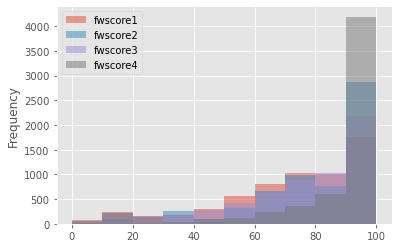

In [526]:
# Check histogram of fuzzy scores, as expected 100% ratio increases because criteria for match becomes more loose
df['fwscore1'].plot(kind='hist',alpha=0.5, legend=1)
df['fwscore2'].plot(kind='hist',alpha=0.5, legend=1)
df['fwscore3'].plot(kind='hist',alpha=0.5, legend=1)
df['fwscore4'].plot(kind='hist',alpha=0.5, legend=1)

In [527]:
df.filter(items=['lcbo_name','viv_name','lcbo_country','viv_country','fwscore1','fwscore2','fwscore3','fwscore4'])

,lcbo_name,viv_name,lcbo_country,viv_country,fwscore1,fwscore2,fwscore3,fwscore4
0,Château Lafite-Rothschild,Château Lafite Rothschild Count De Lafite Bord...,France,France,64,96,66,100
1,Masseto,Masseto Toscana,Italy,Italy,64,100,64,100
2,Château Mouton Rothschild,Château Mouton Rothschild Aile d'Argent Blanc ...,France,France,63,100,62,100
3,Château Margaux,G.G. Ochsner Chateau Margaux Bordeaux,France,France,54,93,56,67
4,Domaine Leroy Clos de la Roche Grand Cru,Leroy Clos de la Roche Grand Cru,France,France,89,100,89,100
...,...,...,...,...,...,...,...,...
6084,Bodacious Smooth Red,Bodacious Smooth Red,Canada,Canada,100,100,100,100
6085,Stel + Mar Premium Red Wine,stel+mar Premium Red,USA,United States,77,85,89,100
6086,Peller Family Vineyards Cabernet Merlot,Watson Family Vineyards Cabernet - Merlot,Canada,Australia,82,85,82,90
6087,Easy Rider Rocket Red can,Sky Rocket Bursting With Flavour Red Blend,Canada,Canada,42,40,45,57
